# Read Celeritas MC truth ROOT output

Use `rootnb.exe` to start the Jupyter server. An Anaconda environment can be
used, as long as the ROOT used is installed from conda itself.

Since ROOT is a C++ interpreter, adding `%%cpp` at the top of a given cell
allows C++ code to be executed. This can be useful while porting code from a
ROOT C++ macro.

In [1]:
from ROOT import TFile, TTree, TLeaf, TCanvas, gDirectory, RDataFrame
import numpy as np

Welcome to JupyROOT 6.26/10


In [2]:
# Open ROOT file and load the TTree
tfile = TFile("celeritas_output.root", "read")
steps_tree = tfile.Get("steps")

In [3]:
# Fetch labels from core_params TTree
params_tree = tfile.Get("core_params")
params_tree.GetEntry(0)
labels = params_tree.action_labels

# Labels follow the action_id values: action_label = labels[action_id]
print(labels)

{ "pre-step", "eloss-range", "physics-discrete-select", "physics-integral-rejected", "ioni-moller-bhabha", "brems-combined", "photoel-livermore", "scat-klein-nishina", "conv-bethe-heitler", "scat-rayleigh", "physics-failure", "along-step-general-linear", "geo-boundary", "geo-propagation-limit", "diagnostics", "step-gather-pre", "step-gather-post" }


## Example manually looping over tree entries and reading leaf values

In [5]:
# Example manually looping over the steps tree

# Loop over maximum of 2 entries to avoid cluttering
entries = [2, steps_tree.GetEntries()]
max_entries = min(entries)

# Loop over TTree entries and print a few leaves
for i in range(max_entries):
    steps_tree.GetEntry(i)
    print("--- Step", i)
    print("event id:", steps_tree.GetLeaf("event_id").GetValue())
    print("track id:", steps_tree.GetLeaf("track_id").GetValue())
    print("step length (cm):", steps_tree.GetLeaf("step_length").GetValue())
    print("dir (pre): ", end="")
    for j in range(3):
        print(steps_tree.GetLeaf("pre_dir").GetValue(j), end = " ")
    print()
    print()



--- Step 0
event id: 0.0
track id: 0.0
step length (cm): 44.49982769207945
dir (pre): 0.5198666288318229 -0.4292205465391231 -0.7385854118893036 

--- Step 1
event id: 0.0
track id: 1.0
step length (cm): 39.60563224677547
dir (pre): 0.733954593624607 0.18726575230281323 0.6528722635491566 



## Example on how to filter data using EList and RDataFrame

In [6]:
# Create a filtered EList based on a set of conditions
steps_tree.Draw(">>e_list", "event_id == 0 && track_id == 10")
e_list = gDirectory.Get("e_list")
e_list.Print("all")

EventList:e_list/event_id == 0 && track_id == 10, number of entries =35, size=1000
    0 :      32      64      96     128     160     192     224     256     288     320 
   10 :     352     384     416     448     480     512     544     576     608     640 
   20 :     672     704     736     768     800     832     864     896     928     960 
   30 :     992    1024    1056    1088    1120 


In [7]:
# Equivalent case but using RDataFrame
# https://root.cern/manual/data_frame/
# https://root.cern/doc/master/classROOT_1_1RDataFrame.html

df = RDataFrame(steps_tree)
filtered_df = df.Filter("event_id == 0 && track_id == 10")
filtered_df.AsNumpy(["track_id"])

{'track_id': ndarray([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
          10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
          10, 10, 10], dtype=int32)}

## Compare results from EList selection and RDataFrame

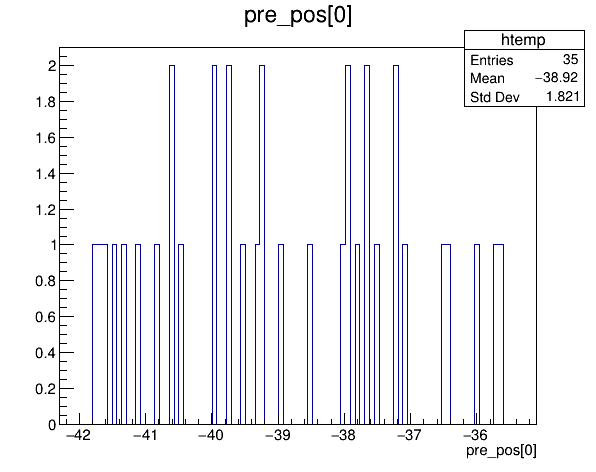

In [8]:
# Limit entries of steps_tree to the filtered entries
steps_tree.SetEventList(e_list)

# Open canvas, draw a given leaf and draw the canvas to the notebook
c1 = TCanvas("c1", "c1", 600, 500)
steps_tree.Draw("pre_pos[0]")
c1.Draw()

In [9]:
# To update plot (colors, axes, titles):
# Draw creates a temporary object stored in canvas
c1.GetListOfPrimitives().ls()

OBJ: TList	TList	Doubly linked list : 0
 TFrame  X1= -42.300000 Y1=0.000000 X2=-35.100000 Y2=2.100000
 OBJ: TH1F	htemp	pre_pos[0] : 1 at: 0x7fee05af9be0
 OBJ: TPaveText	title  	X1= -39.703591 Y1=2.189206 X2=-37.696409 Y2=2.349375


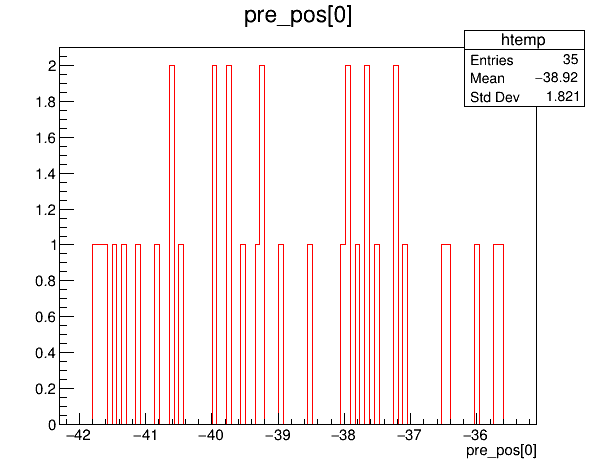

In [10]:
# Fetch histogram and update a random paramater
histo_elist = c1.GetListOfPrimitives().FindObject("htemp")
histo_elist.SetLineColor(2)
histo_elist.Draw()
c1.Draw()

In [11]:

# Create histogram using RDataFrame

# For dir and pos, which are arrays of size 3
histo_df = filtered_df.Define("pos_x","pre_pos[0]").Histo1D("pos_x")

# For all other values
# histo_df = filtered_df.Histo1D("action_id")


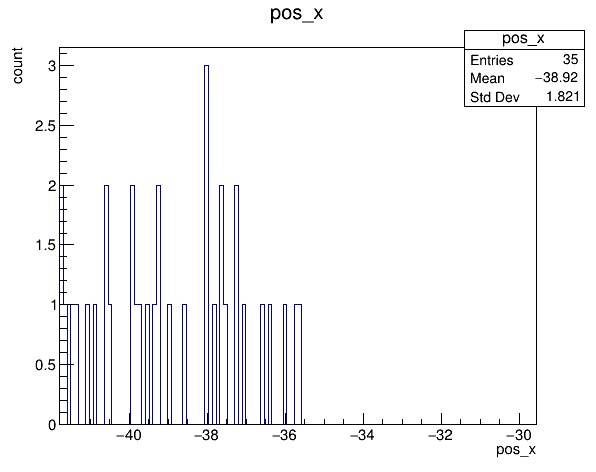

In [12]:
histo_df.Draw()
c1.Draw()